In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC



# Load the dataset
file_path = f'../cohorts/cohort4.csv'
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,Unnamed: 0,External,Year,session 1,session 2,test 1,session 3,session 4,test 2,session 5,test 3,session 6,ind cw,group cw,final grade,fourm Q,fourm A,office hour visits,final_dropout,completion_stage
0,1,0,3,71,77,1,40.0,67.0,1.0,69.0,1.0,41.0,1.0,1.0,4.0,13,4,4,0,3
1,2,1,1,32,62,5,76.0,77.0,1.0,35.0,5.0,93.0,5.0,5.0,2.0,16,9,3,0,3
2,3,1,1,8,4,5,46.0,36.0,3.0,93.0,2.0,79.0,1.0,4.0,2.0,22,4,6,0,3
3,4,1,1,6,1,5,23.0,33.0,4.0,90.0,3.0,82.0,3.0,1.0,3.0,19,9,7,0,3
4,6,1,2,9,25,5,22.0,40.0,3.0,72.0,2.0,32.0,3.0,2.0,1.0,12,3,7,0,3


In [6]:
# Drop the index column (not needed)
df = df.drop(columns=["Unnamed: 0"])

# Rename drop column to dropout for all cohorts
drop_col = [col for col in df.columns if "drop" in col.lower()]
df = df.rename(columns={drop_col[0]: "dropout"})

# Get Session Average
session_cols = [col for col in df.columns if "session" in col.lower()]
# Create the new column as the row-wise average of those columns
df["session average"] = df[session_cols].mean(axis=1)

# Get Test Score Average
test_cols = [col for col in df.columns if "test" in col.lower() and "dropped" not in col.lower()]
# Create the new column as the row-wise average of those columns
df["test average"] = df[test_cols].mean(axis=1)

# Get Forum Average
forum_cols = [col for col in df.columns if "forum" in col.lower() or "fourm" in col.lower()]
# Create the new column as the row-wise average of those columns
df["forum average"] = df[forum_cols].mean(axis=1)

# Create list of features (column names)
features = [col for col in df.columns if "average" in col.lower() or "office" in col.lower()]

# check
df.head()

,External,Year,session 1,session 2,test 1,session 3,session 4,test 2,session 5,test 3,...,group cw,final grade,fourm Q,fourm A,office hour visits,dropout,completion_stage,session average,test average,forum average
0,0,3,71,77,1,40.0,67.0,1.0,69.0,1.0,...,1.0,4.0,13,4,4,0,3,60.833333,1.000000,8.5
1,1,1,32,62,5,76.0,77.0,1.0,35.0,5.0,...,5.0,2.0,16,9,3,0,3,62.500000,3.666667,12.5
2,1,1,8,4,5,46.0,36.0,3.0,93.0,2.0,...,4.0,2.0,22,4,6,0,3,44.333333,3.333333,13.0
3,1,1,6,1,5,23.0,33.0,4.0,90.0,3.0,...,1.0,3.0,19,9,7,0,3,39.166667,4.000000,14.0
4,1,2,9,25,5,22.0,40.0,3.0,72.0,2.0,...,2.0,1.0,12,3,7,0,3,33.333333,3.333333,7.5


In [7]:
features

['office hour visits', 'session average', 'test average', 'forum average']

# Naive Bayes

In [8]:
# Split into features and target
X = df.drop(columns=["dropout"])
y = df["dropout"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Use model to predict the outcome based on training dataset
y_predicted = gnb.predict(X_test)
y_predicted

array([0, 0, 0, ..., 0, 1, 0])

In [9]:
# Create a dataframe to combine predicted values and their true values
results = pd.DataFrame({'y_real':y_test, 'y_predicted':y_predicted})
results["is_correct"] = results['y_real'] == results["y_predicted"]
results.head()

,y_real,y_predicted,is_correct
7498,0,0,True
1634,0,0,True
6667,0,0,True
2865,1,1,True
6669,1,1,True


In [10]:
# Check results for NB
print("Correct predictions: " + str(len(results[results.is_correct == True])))
print("Wrong predictions: " + str(len(results[results.is_correct == False])))
nb_accuracy = (round(100*len(results[results.is_correct == True])/len(results),2))
print("Percentage of correct predictions: " + str(round(100*len(results[results.is_correct == True])/len(results),2)) + "%")

Correct predictions: 1474
Wrong predictions: 144
Percentage of correct predictions: 91.1%


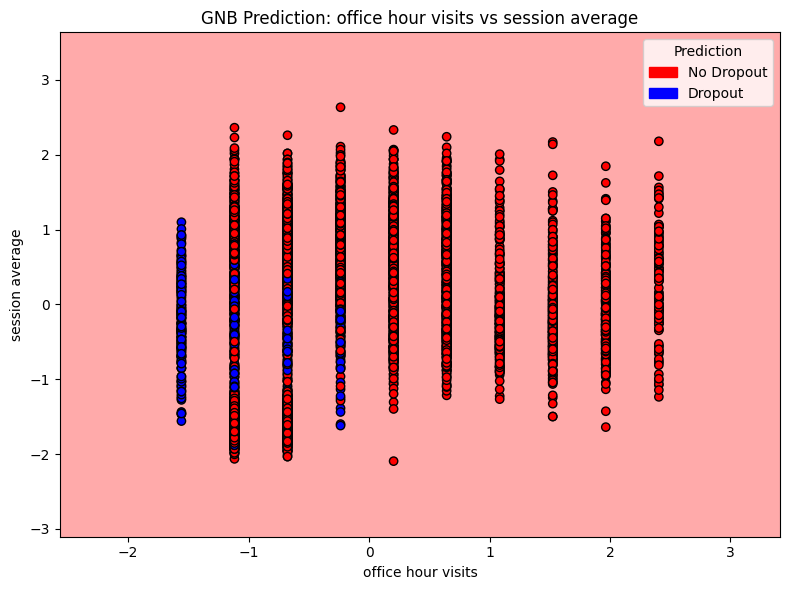

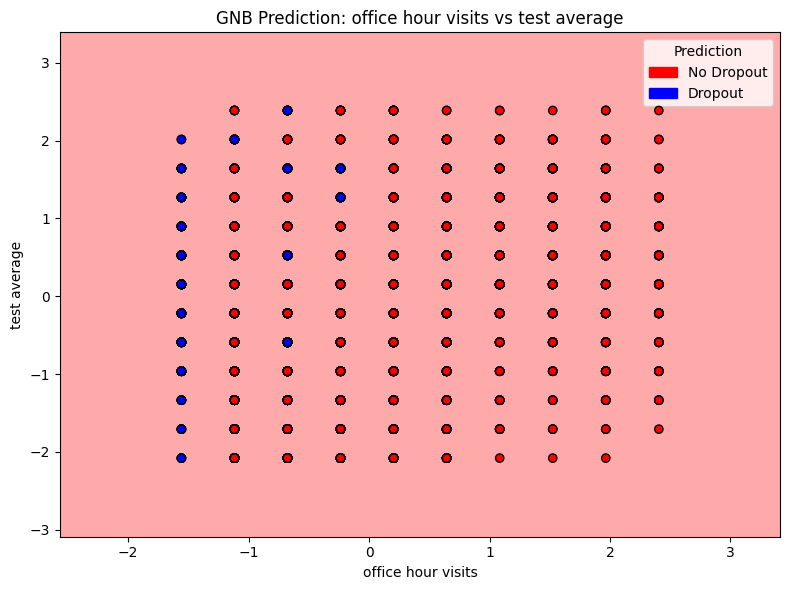

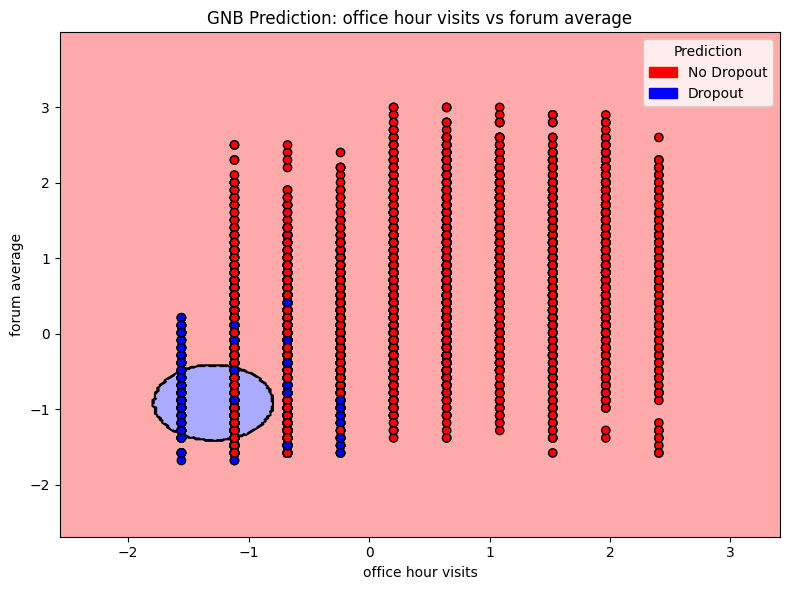

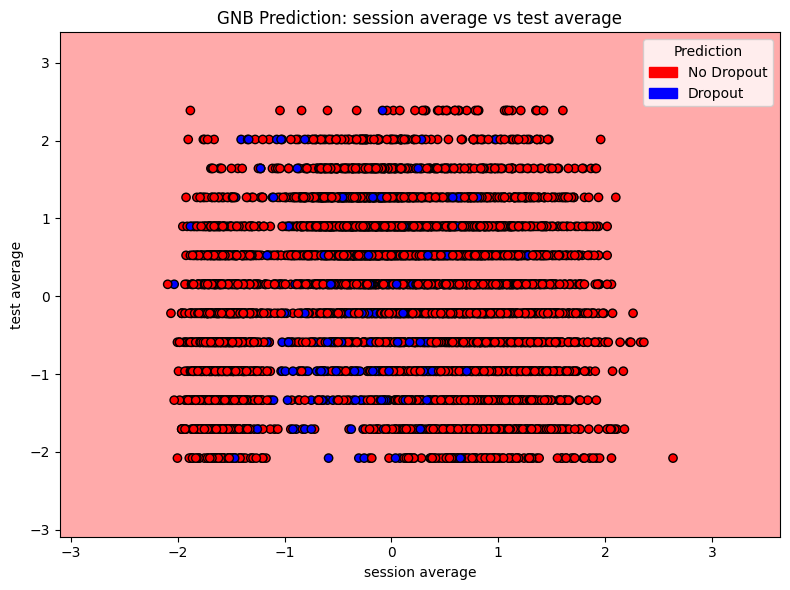

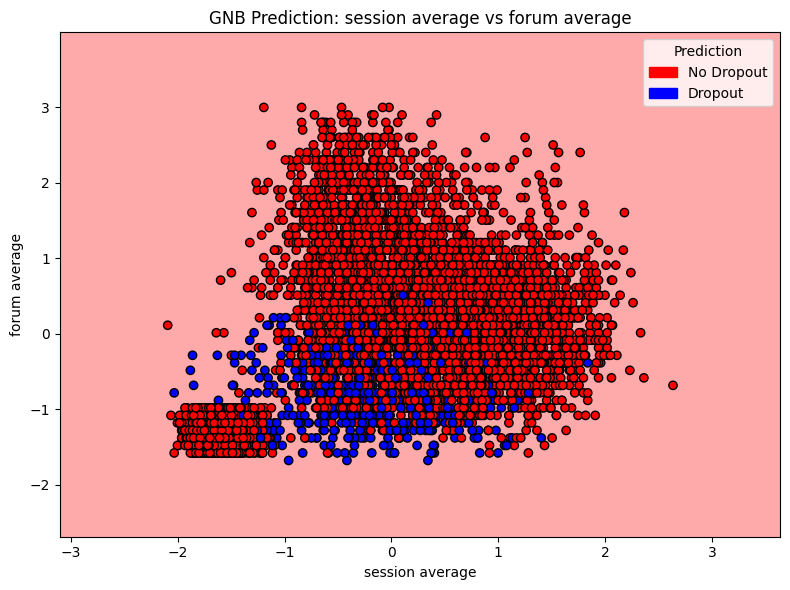

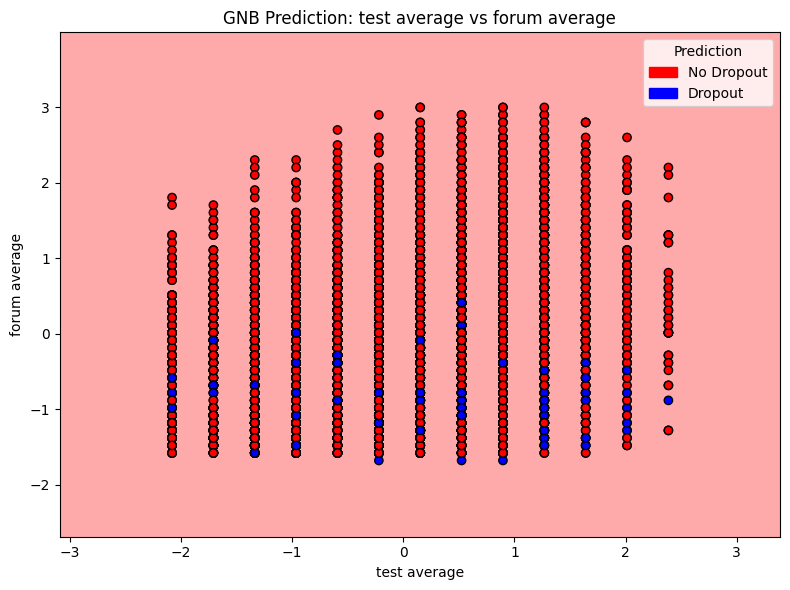

In [11]:
# Plot NB
import itertools

# Cycle through pairs of features to plot
for feat1, feat2 in itertools.combinations(features, 2):
    # Select feature pair
    X = df[[feat1, feat2]]
    y = df["dropout"]

    # Train-test split
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Fit GaussianNB
    gnb = GaussianNB()
    gnb.fit(X_train_scaled, y_train)

    # Create mesh grid
    h = 0.02  # step size
    x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
    y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['red', 'blue'])

    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, zorder=10,
            cmap=cmap_bold, edgecolors='k')
    plt.contour(xx, yy, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
            levels=[-.5, 0, .5]) #draws line

    # Labels and title
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f"GNB Prediction: {feat1} vs {feat2}")

    # Legend
    legend_labels = ['No Dropout', 'Dropout']
    handles = [mpatches.Patch(color=cmap_bold(i), label=label) for i, label in enumerate(legend_labels)]
    plt.legend(handles=handles, title="Prediction")

    plt.tight_layout()
    plt.show()

# SVM

In [12]:
# Split into features and target
X = df.drop(columns=["dropout"])
y = df["dropout"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVC
svc = SVC(kernel ='rbf')
svc.fit(X_train_scaled, y_train)
svm_preds = svc.predict(X_test_scaled)

In [13]:
# Create a dataframe to combine predicted values and their true values
results = pd.DataFrame({'y_real':y_test, 'y_predicted':svm_preds})
results["is_correct"] = results['y_real'] == results["y_predicted"]
results.head()

,y_real,y_predicted,is_correct
7498,0,0,True
1634,0,0,True
6667,0,0,True
2865,1,1,True
6669,1,1,True


In [14]:
# Check results for SVC
print("Correct predictions: " + str(len(results[results.is_correct == True])))
print("Wrong predictions: " + str(len(results[results.is_correct == False])))
svm_accuracy = (round(100*len(results[results.is_correct == True])/len(results),2))
print("Percentage of correct predictions: " + str(round(100*len(results[results.is_correct == True])/len(results),2)) + "%")

Correct predictions: 1593
Wrong predictions: 25
Percentage of correct predictions: 98.45%


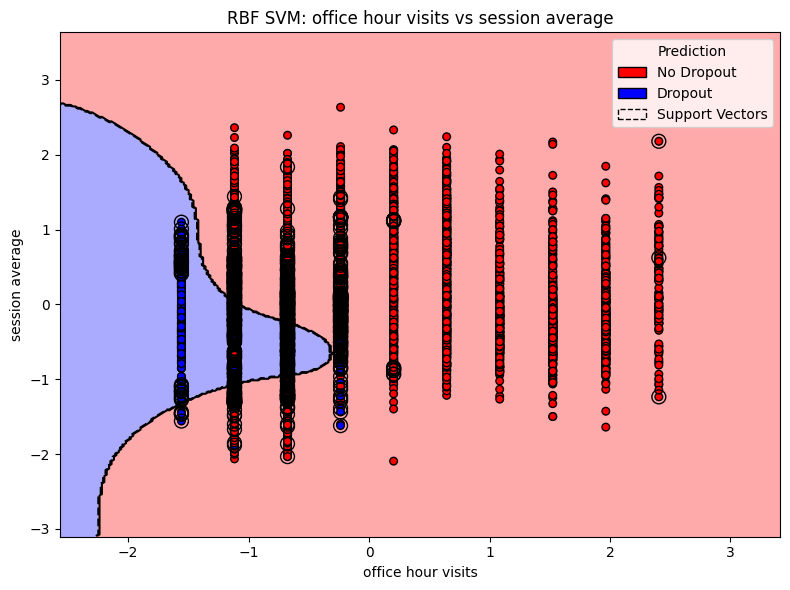

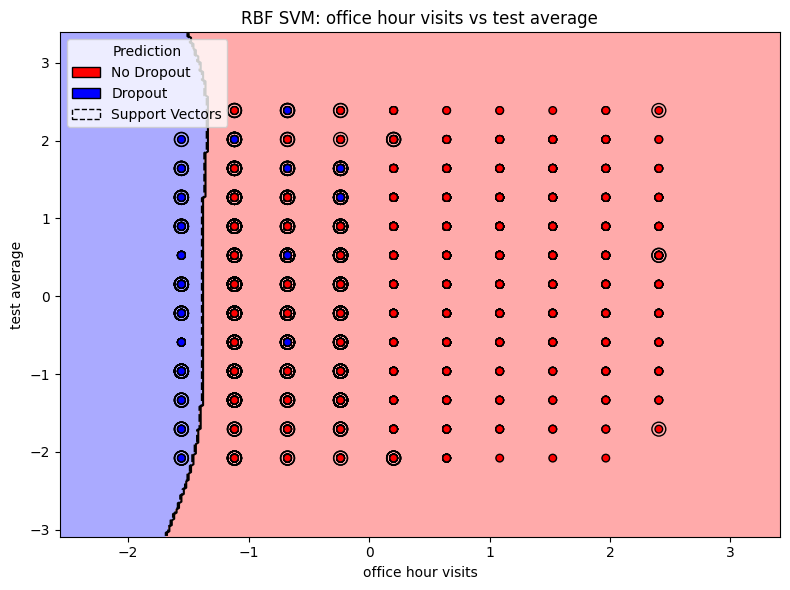

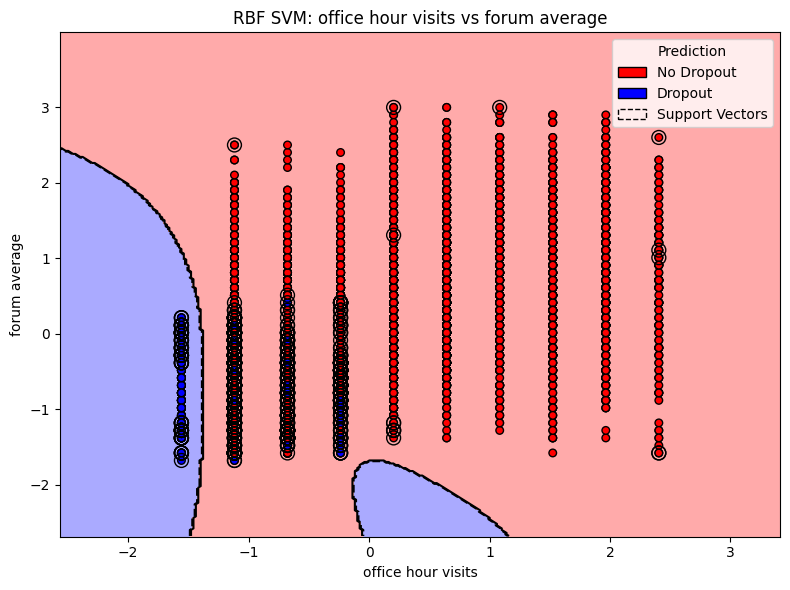

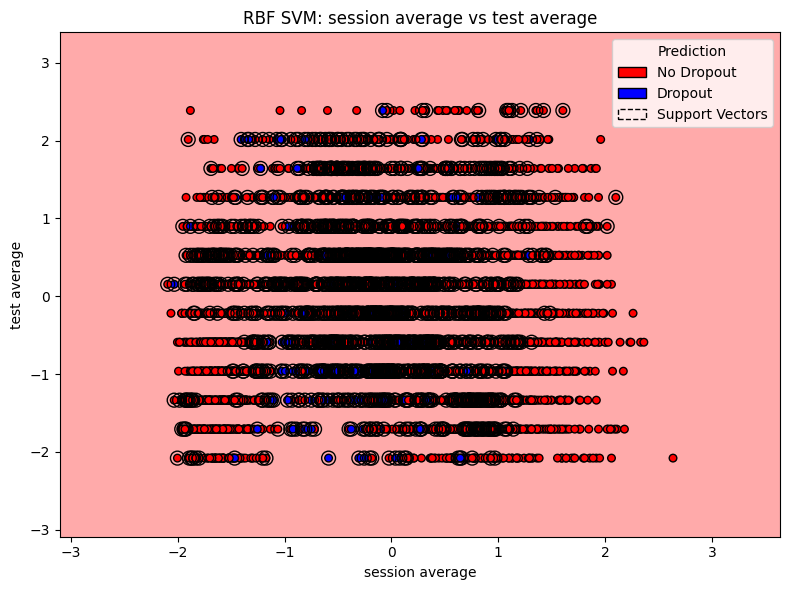

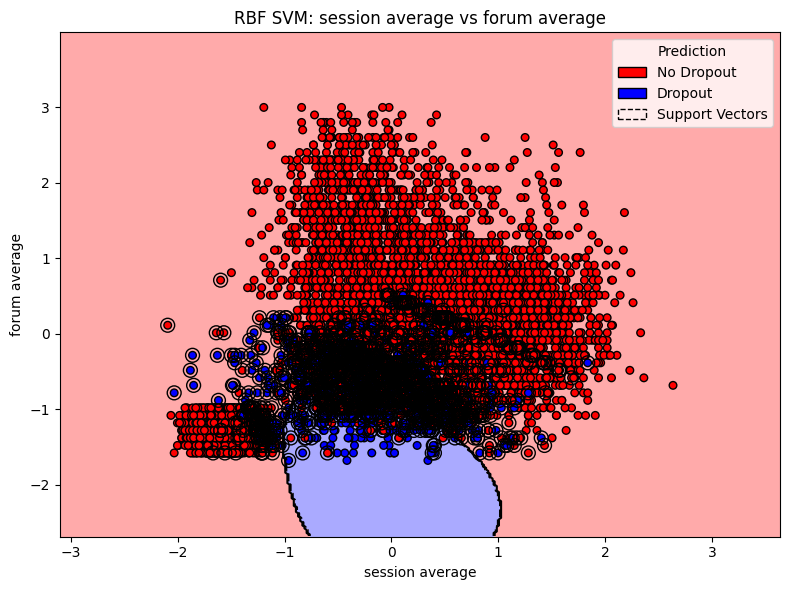

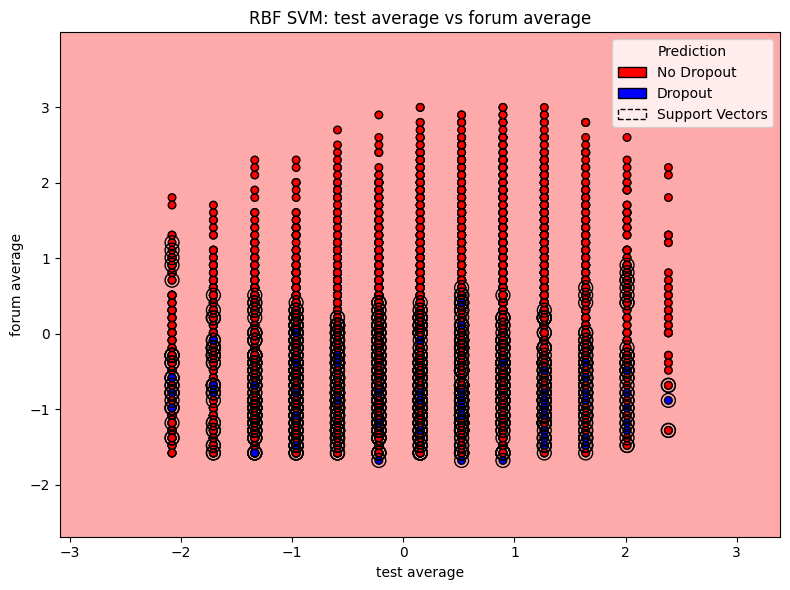

In [15]:
# Plot SVC
from matplotlib.patches import Patch

# Cycle through pairs of features to plot
for feat1, feat2 in itertools.combinations(features, 2):
    # Select pair of features
    X = df[[feat1, feat2]]
    y = df["dropout"]

    # Train-test split
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # Train SVM with RBF kernel
    svc = SVC(kernel='rbf', gamma='scale')
    svc.fit(X_scaled, y_train)

    # Create mesh grid
    h = 0.02
    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict over grid
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision regions
    plt.figure(figsize=(8, 6))
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['red', 'blue'])

    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot training points
    sc = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_train, cmap=cmap_bold,
                     edgecolor='k', s=30)


    # Plot support vectors
    plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolors='k', label='Support Vectors')
    plt.contour(xx, yy, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
            levels=[-.5, 0, .5])#draws line

    # Title and labels
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f"RBF SVM: {feat1} vs {feat2}")

    # Legend
    legend_elements = [
        Patch(facecolor='red', edgecolor='k', label='No Dropout'),
        Patch(facecolor='blue', edgecolor='k', label='Dropout'),
        Patch(facecolor='none', edgecolor='k', label='Support Vectors', linestyle='--')
    ]
    plt.legend(handles=legend_elements, title="Prediction")

    plt.tight_layout()
    plt.show()

# Accuracy Summary

In [16]:
summary_df = pd.DataFrame({
    'Classifier': ['Naive Bayes', 'SVM'],
    'Accuracy (%)': [round(nb_accuracy, 2), round(svm_accuracy, 2)]
})

print(summary_df)

    Classifier  Accuracy (%)
0  Naive Bayes         91.10
1          SVM         98.45
